Download data from internet!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse.linalg
import scipy.stats
from scipy.ndimage.filters import gaussian_filter1d,gaussian_filter
from six.moves import urllib
import os
import sklearn.decomposition
from PIL import Image

# before we start install UMAP
# (see documentation here https://github.com/lmcinnes/umap)
# pip install umap-learn

# download image set from UPenn
if not os.path.isfile('image_data/img1.jpg'):
    if not os.path.exists('image_data'):
        os.mkdir('image_data')
    for d in range(66):
        with urllib.request.urlopen('ftp://tofu.psych.upenn.edu/fulldb/cd01A/DSC_%04d.JPG'%(d+1)) as response:
            with open('image_data/img%d.jpg'%d,'wb') as f:
                f.write(response.read())

# download 2-photon data
if not os.path.isfile('data/mesoscope_activity.npy'):
    if not os.path.exists('data'):
        os.mkdir('data')
    with urllib.request.urlopen('http://www.gatsby.ucl.ac.uk/~cstringer/mesoscope_activity.npy') as response:
        with open('data/mesoscope_activity.npy','wb') as f:
            f.write(response.read())

## Large-scale neural recordings

The neural data was collected using the mesoscope, the data spans sensorimotor cortex. The mouse was not doing a task, it was in darkness, free to run and whisk and groom as it pleased.

dict_keys(['spks', 'xyloc'])
number of neurons: 6670 ; number of timepoints: 6668


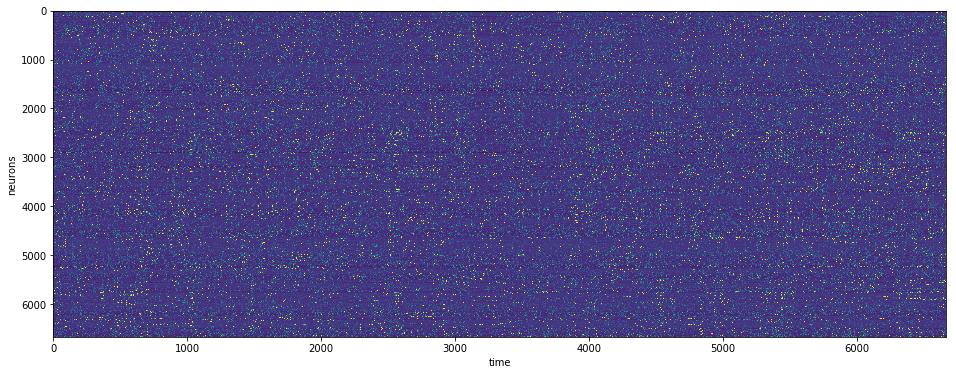

In [27]:
from scipy.stats import zscore

dat = np.load('data/mesoscope_activity.npy').item()
print(dat.keys())

# make activity mean 0 and standard deviation 1
X = zscore(dat['spks'], axis=1)
xyloc = dat['xyloc']
del dat

print('number of neurons: %d ; number of timepoints: %d'%(X.shape[0],X.shape[1]))

# make large figure
fig=plt.figure(figsize=(16,6))
# add subplot to figure
ax = fig.add_subplot(111)
# plot spikes
# (imshow is like imagesc in matlab, with vmin and vmax setting range)
ax.imshow(X, vmin=-1, vmax=4, aspect='auto')
ax.set_xlabel('time')
ax.set_ylabel('neurons');

We can't really see any structure in this activity, we should try to put neurons with similar activity near each other to see the structure. Algorithms that do this type of clustering include k-means, tSNE, UMAP. We have our own algorithm that is fast to run that is called "rastermap". To install it run the following block of code:

In [ ]:
!pip install rastermap

Now that it's installed, we will run it on this neural activity to sort the neurons.

nmin 400
0.11110353469848633
4.916722774505615
5.001721382141113
5.027742385864258
(98, 100)
(130,)
1.0
time; iteration;  explained PC variance
0.04s     0        0.0179      2
0.44s    10        0.0982      4
0.85s    20        0.1251      8
1.29s    30        0.1645      18
1.86s    40        0.1853      28
2.22s    50        0.2001      38
2.67s    60        0.2106      48
3.11s    70        0.2192      58
3.56s    80        0.2259      68
4.12s    90        0.2318      78
4.57s    100        0.2389      88
4.97s    110        0.2451      98
5.41s    120        0.2462      98
5.83s   final      0.2466
5.84s upsampled    0.2466


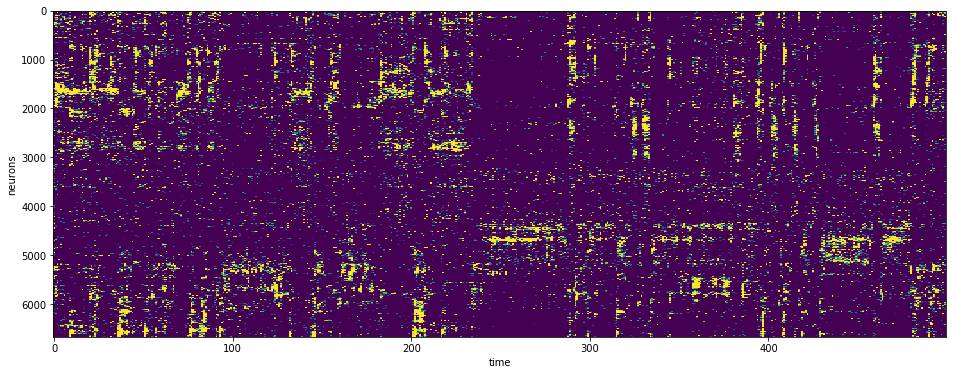

In [64]:
from rastermap import Rastermap # (pip install rastermap)
# run rastermap on neural data example
# this is like tSNE, we just need a way to sort neurons
# rastermap puts neurons with similar firing patterns near each other
rastermap = Rastermap(n_components=1, n_X=100, nPC=400).fit(X)
isort = np.argsort(rastermap.embedding[:,0])

def plot_sorting(sp, isort, tpts, ax):
    ax.imshow(gaussian_filter1d(sp[isort,:tpts],5,axis=0),aspect='auto',vmin=0.2,vmax=.6)
    ax.set_xlabel('time')
    ax.set_ylabel('neurons')

fig=plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
plot_sorting(X, isort, 500, ax)


Now we can see some structure in the data. How "high-dimensional" is this structure? Can we capture it with just a few principal components?

Find the principal components using PCA.fit from scikit-learn. Also look at the documentation and find the "singular values". Make the components size [neurons x components] (requires a transpose ".T")

In [6]:
# first find principal components of spks using PCA

from sklearn.decomposition import PCA

#~~~ pca = PCA(n_components=1000).fit(X.T)
#~~~ U = pca.components_.T
#~~~ S = pca.singular_values_


Now try to reconstruct the data using d PC's. 

Recall that 
$$ X \approx USV^\top $$
We found $U$ and $S$ in the previous cell. How do we compute $V$?
$$ V^\top = S^{-1} U^\top X  $$
Therefore, the reconstruction of $X$ using $U$ is 
$$ X \approx U S (S^{-1} U^\top X) $$
$$ X \approx U (U^\top X) $$
with equality if $U$ has as many components as neurons in $X$.

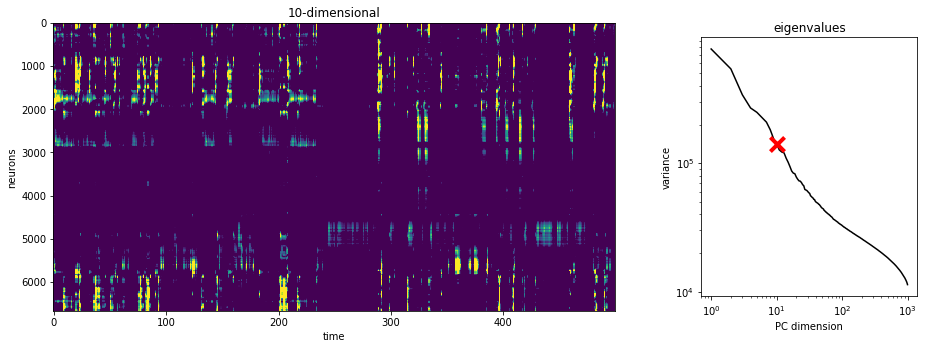

In [21]:
# next compute low-dimensional reconstruction of spks
d = 10 # 10 dimensions

#~~~ xlowd = U[:,:d] @ (U[:,:d].T @ X)

fig = plt.figure(figsize=(12,4)); 
# large subplot
ax1 = plt.axes([0,0,.65,1])
plot_sorting(xlowd, isort, 500, ax1)    
ax1.set_title(('%d-dimensional'%(d)))

ax2 = plt.axes([0.75,0.05,.25,.9])
ax2.loglog(np.arange(1,S.size+1),S**2,color='k')
ax2.scatter(d, S[d-1]**2,color='r',marker='x',s=200,lw=4,zorder=10)
ax2.set_title('eigenvalues')
ax2.set_xlabel('PC dimension')
ax2.set_ylabel('variance')
plt.show()

What if I told you the first 32 PCs mostly represent running/whisking? What if I wanted to subtract that activity and see what's left over without it?

Why might you want this? Suppose this animal was doing a task, you might not care about the responses to running or whisking, you only care about the neural activity related to the stimuli that you are presenting, like odors, or lights, or sounds. Therefore you may want to subtract out this "subspace" of neural activity:

$$ X_\text{sub} = X - U_\text{beh} (U_\text{beh}^\top X)$$

Please do this yourself and plot the activity:

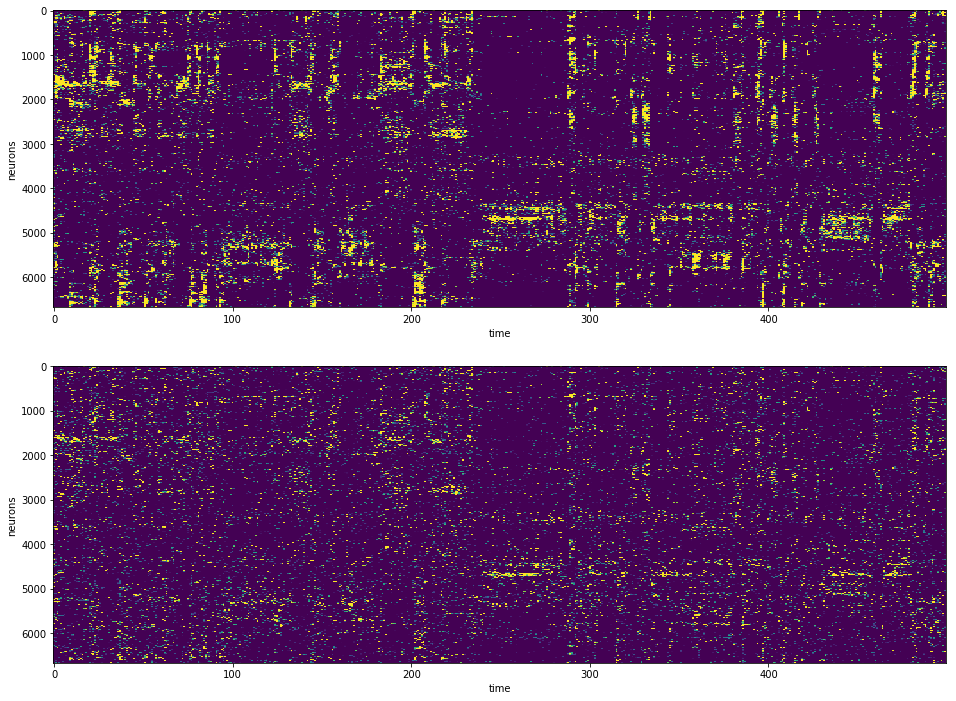

In [75]:
#~~~ xsub = X -  U[:,:32] @ (U[:,:32].T @ X)

fig=plt.figure(figsize=(16,12))
ax = fig.add_subplot(211)
plot_sorting(X, isort, 500, ax)

# first PC subtracted
ax = fig.add_subplot(212)
plot_sorting(xsub, isort, 500, ax)


Much of the structure we found using rastermap is gone, but there are still smaller groups of neurons covarying. This is not so surprising when we think about the eigenvalue spectrum - there is no real cut-off, but there is more variance in the top 32 PCs than in the next 1000.

## The structure of natural images

We will now look at the principal components of natural images.

In [76]:
# extract patches from images and make them grayscale!
nyp = 35
nxp = 35
n0 = 250
imgs = np.zeros((66*n0,nyp,nxp),dtype=np.uint8)    
for d in range(66):
    # load in image
    img = np.array(Image.open('image_data/img%d.jpg'%d))
    # mean over color channel (axis=2)
    img = np.round((img.astype(np.float32)).mean(axis=2)).astype(np.uint8)
    ny,nx = img.shape
    # take n0 = 250 random patches from each image
    for k in range(n0):
        # random integers from where to grab patch
        ry = np.random.randint(ny-nyp)
        rx = np.random.randint(nx-nxp)
        imgs[k+d*n0,:,:] = img[ry:ry+nyp, rx:rx+nxp]
        

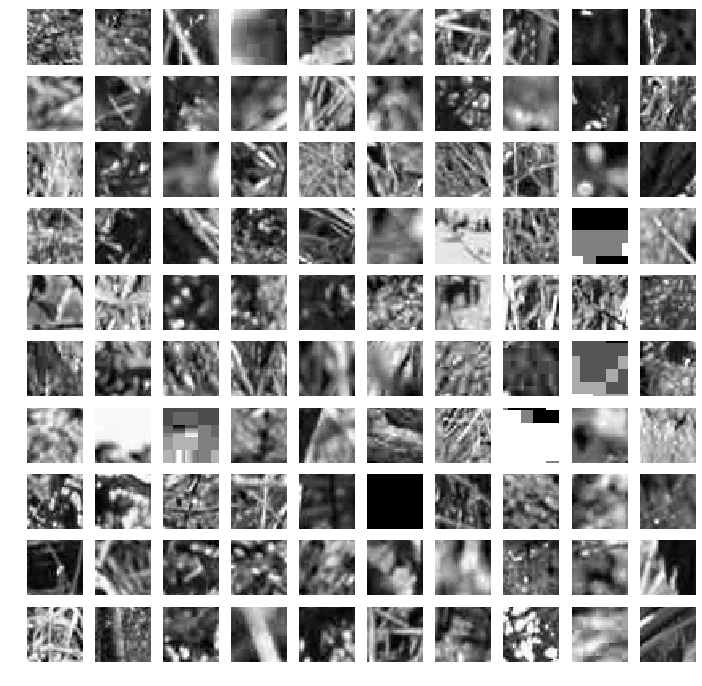

In [77]:
# make large figure
fig=plt.figure(figsize=(12,12))
for n in range(100):
    # add subplot to figure
    ax = fig.add_subplot(10,10,n+1)
    # plot random image patch
    # (imshow is like imagesc in matlab)
    ax.imshow(imgs[np.random.randint(imgs.shape[0]),:,:], cmap=plt.get_cmap('gray'))
    ax.axis('off')

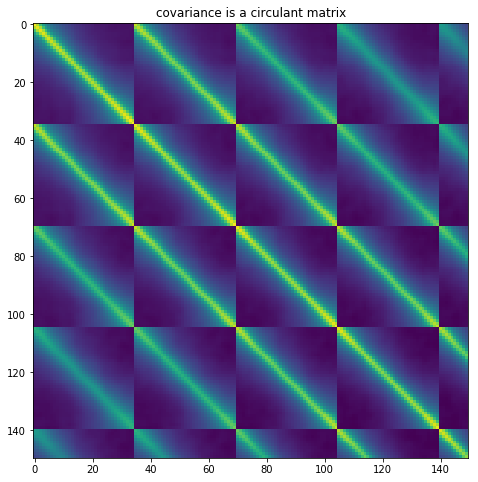

In [78]:
# first flatten the images
imgflat = np.reshape(imgs,(imgs.shape[0],-1))

### we find the principal components of the covariance matrix
# compute covariance of images
imgcov = (imgflat-imgflat.mean(axis=1)[:,np.newaxis]).T @ (imgflat-imgflat.mean(axis=1)[:,np.newaxis])

fig=plt.figure(figsize=(8,8))
plt.imshow(imgcov[:150,:150])
plt.title('covariance is a circulant matrix')
plt.show()

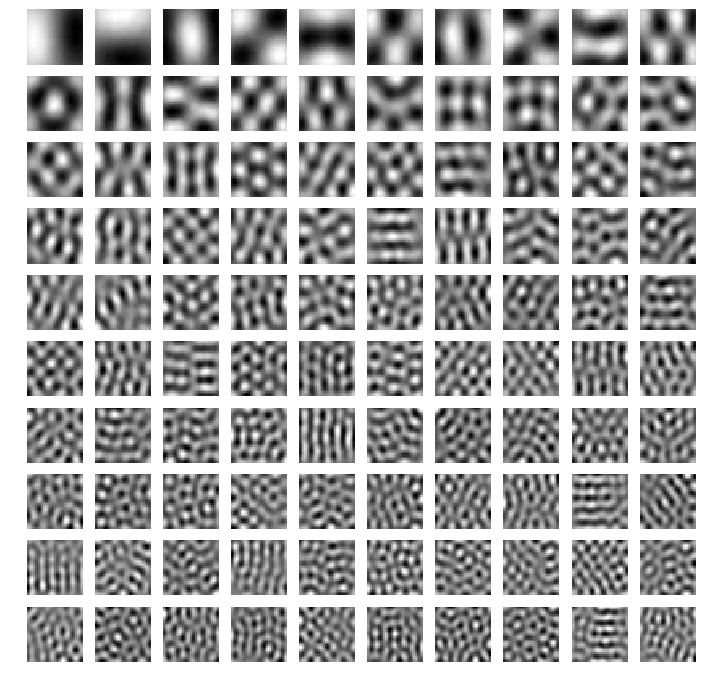

In [81]:
### compute eigenvectors
#~~~ pca = PCA(n_components=100).fit(imgcov)
#~~~ U = pca.components_.T
#~~~ S = pca.singular_values_

# visualize the PCs
fig=plt.figure(figsize=(12,12))
for n in range(100):
    ax = fig.add_subplot(10,10,n+1)
    ax.imshow(np.reshape(U[:,n],(nyp,nxp)), cmap=plt.get_cmap('gray'))
    ax.axis('off')

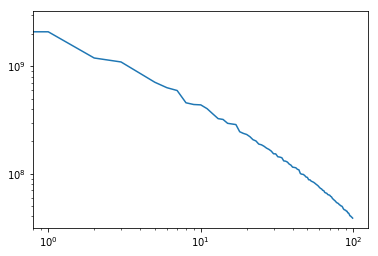

In [85]:
# eigenvalue spectrum (look familiar)?
plt.loglog(S)

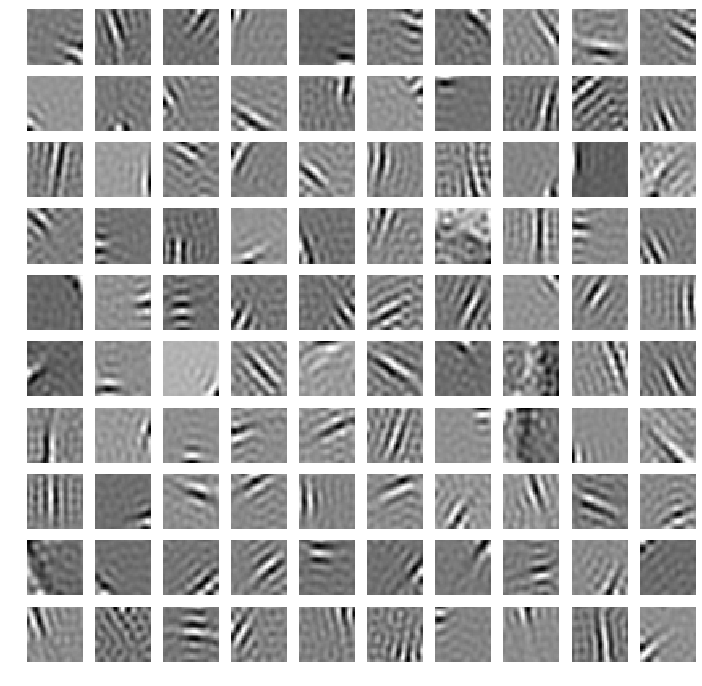

In [10]:
##### BONUS:
### find the independent components! (ICA)
model = sklearn.decomposition.FastICA(n_components=100,algorithm='parallel')
# flattened and mean-centered data
model = model.fit(imgflat - imgflat.mean(axis=1)[:,np.newaxis])
s = model.components_

# visualize the ICs
fig=plt.figure(figsize=(12,12))
for n in range(100):
    ax = fig.add_subplot(10,10,n+1)
    ax.imshow(np.reshape(s[n,:],(nyp,nxp)), cmap=plt.get_cmap('gray'))
    ax.axis('off')
    #ax.set_title('IC %d'%(n+1))